<a href="https://colab.research.google.com/github/Minseo-202103621/machinelearning_deeplearning/blob/main/CH)08_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 합성곱 신경망의 시각화
## 합성곱 층의 가중치와 특성 맵을 시각화하여 신경망이 이미지에서 어떤 것을 학습하는지 이해해 보자

이번에는 합성곱 층의 가중치와 특성 맵을 그림으로 시각화해 보겠다.

이를 통해 합성곱 신경망의 동작원리에 대한 통찰을 키울 수 있다.

지금까지는 케라스의 Sequential 클래스만 사용했다. 케라스는 좀 더 복잡한 모델을 만들 수 있는 함수형 API를 제공한다. 이번 절에서 함수형 API가 무엇인지 살펴보고 합성곱 층의 특성 맵을 시각화하는데 사용해 보겠다.

이 절에서는 2절에서 훈련했던 합성곱 신경망의 체크 포인트 파일을 사용한다.

이 파일은 최적의 에포크까지 훈련한 모델 파라미터를 저장하고 있다.

---

# 가중치 시각화

합성곱 층은 여러 개의 필터를 사용해 이미지에서 특징을 학습한다. 각 필터는 커널이라고 부르는 가중치와 절편을 가지고 있다. 일반적으로 절편은 시각적으로 의미가 있지 않다. 가중치는 입력 이미지의 2차원 영역에 적용되어 어떤 특징을 크게 두드러지게 표현하는 역할을 한다.

예를 들어 다음과 같은 가중치는 둥근 모서리가 있는 영역에서 크게 활성화되고 그렇지 않은 영역에서는 낮은 값을 만든다.

<그림>

이 필터의 가운데 곡선 부분의 가중치 값은 높고 그 외 부분의 가중치 값은 낮을 것이다. 이렇게 해야 둥근 모서리가 있는 입력과 곱해져서 큰 출력을 만들기 때문이다.

그럼 2절에서 만든 모델이 어떤 가중치를 학습했는지 확인하기 위해 체크포인트 파일을 읽어 들이겠다.



In [5]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

model = keras.Sequential()

model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                              padding='same', input_shape=(28,28,1)))

model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

4422102/4422102 [==============================] - 0s 0us/step
Epoch 1/20
1500/1500 [==============================] - 83s 55ms/step - loss: 0.5223 - accuracy: 0.8113 - val_loss: 0.3426 - val_accuracy: 0.8682
Epoch 2/20
1500/1500 [==============================] - 100s 67ms/step - loss: 0.3464 - accuracy: 0.8750 - val_loss: 0.2772 - val_accuracy: 0.8971
Epoch 3/20
1500/1500 [==============================] - 86s 57ms/step - loss: 0.2949 - accuracy: 0.8932 - val_loss: 0.2563 - val_accuracy: 0.9028
Epoch 4/20
1500/1500 [==============================] - 84s 56ms/step - loss: 0.2639 - accuracy: 0.9027 - val_loss: 0.2412 - val_accuracy: 0.9077
Epoch 5/20
1500/1500 [==============================] - 110s 74ms/step - loss: 0.2383 - accuracy: 0.9121 - val_loss: 0.2400 - val_accuracy: 0.9124
Epoch 6/20
1500/1500 [==============================] - 79s 53ms/step - loss: 0.2189 - accuracy: 0.9187 - val_loss: 0.2216 - val_accuracy: 0.9187
Epoch 7/20
1500/1500 [==============================] - 75s

In [6]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',save_best_only=True)
from tensorflow import keras
model = keras.models.load_model('best-cnn-model.h5')

케라스 모델에 추가한 층은 layers 속성에 저장되어 있다. 이 속성은 파이썬 리스트이다.
* model.layers를 출력해 보겠다.


In [7]:
model.layers

model.layers 리스트에 이전 절에서 추가했던 Conv2D,MaxPooling2D 층이 번갈아 2번 연속 등장한다. 그다음 Flatten 층과 Dense 층,Dropout 층이 차례대로 등장한다. 마지막에 Dense 출력층이 놓여 있다.

그럼 첫 번째 합성곱 층의 가중치를 조사해 보자. 층의 가중치와 절편은 층의 weights 속성에 저장되어 있다. weights도 파이썬 리스트이다. 다음 코드에서처럼 layers 속성의 첫 번째 원소를 선택해 weights의 첫 번째 원소(가중치)와 두 번째 원소(절편)의 크기를 출력해 보자.



In [8]:
conv = model.layers[0]
print(conv.weights[0].shape,conv.weights[1].shape)

(3, 3, 1, 32) (32,)


이전 절에서 커널 크기를 (3,3)으로 지정했다. 이 합성곱 층에 전달되는 입력의 깊이가 1이므로 실제 커널 크기는 (3,3,1)이다. 또 필터 개수가 32개이므로 wieghts의 첫 번째 원소인 가중치의 크기는 (3,3,1,32)가 됐다. weights의 두 번째 원소는 절편의 개수를 나타낸다. 필터마다 1개의 절편이 있으므로 (32,) 크기가 된다.


weights 속성은 텐서플로의 다차원 배열인 Tensor 클래스의 객체이다. 여기서는 다루기 쉽도록 numpy() 메서드를 사용해 넘파이 배열로 변환하겠다. 그 다음 가중치 배열의 평균과 표준편차를 넘파이 mean() 메서드와 std() 메서드로 계산해 보자.


In [9]:
conv_weights = conv.weights[0].numpy()
print(conv_weights.mean(),conv_weights.std())


-0.030061029 0.26344478


이 가중치의 평균값은 0에 가깝고 표준편차는 0.27이다. 나중에 이 값을 훈련하기 전의 가중치와 비교해 보겠다. 이 가중치가 어떤 분포를 가졌는지 직관적으로 이해하기 쉽도록 히스토그램을 그려 보겠다.



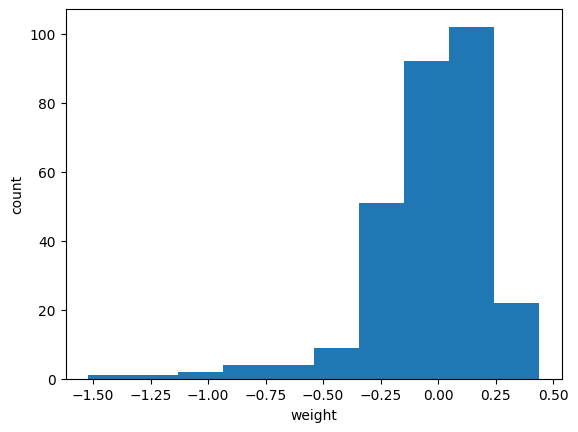

In [10]:
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()


맷플롯립의 hist() 함수에는 히스토그램을 그리기 위해 1차원 배열로 전달해야 한다.

이를 위해 넘파이 reshape 메서드로 conv_weights 배열을 1개의 열이 있는 배열로 변환해야 한다.

히스토그램을 보면 0을 중심으로 종 모양 분포를 띠고 있는 것을 알 수 있다.

이 가중치가 무엇인가 의미를 학습한 것일까?

잠시 후에 훈련하기 전의 가중치와 비교해 보도록 하겠다.

이번에는 32개의 커널을 16개씩 두 줄에 출력해 보겠다.

맷플롯립의 subplots() 함수를 사용해 32개의 그래프 영역을 만들고 순서대로 커널을 출력하겠다.



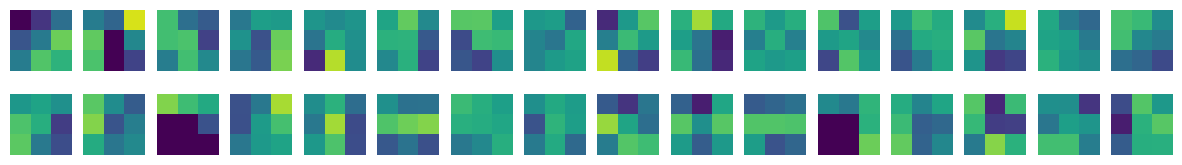

In [11]:
fig,axs = plt.subplots(2,16,figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i,j].imshow(conv_weights[:,:,0,i*16 + j],vmin=-0.5,vmax=0.5)
    axs[i,j].axis('off')

plt.show()

결과 그래프를 보면 무작위 나열이 아니라 어떤  패턴을 볼 수 있다.

예를 들어 첫 번째 줄의 맨 왼쪽 가중치는 오른쪽 3픽셀의 값이 높다.(밝은 부분의 값이 높다) 이 가중치는 오른쪽에 놓인 직선을 만나면 크게 활성화될 것이다.

imshow() 함수는 배열에 있는 최대값과 최소값을 사용해 픽셀의 강도를 표현한다.

즉 0.1이나 0.4나 어떤 값이든지 그 배열의 최대값이면 가장 밝은 노란 색으로 그린다. 만약 두 배열을 비교하려면 이런 동작은 바람직하지 않다.

어떤 절대값으로 기준을 정해서 픽셀의 강도를 나타내야 비교하기 좋다.

이를 위해 위 코드에서 vmin과 vmax로 맷플롯립의  컬러맵으로 표현할 범위를 지정했다.

이번에는 훈련하지 않은 빈 합성곱 신경망을 만들어 보겠다. 이 합성곱 층의 가중치가 위에서 본 훈련한 가중치와 어떻게 다른지 그림으로 비교해 보겠다.
* 먼저 Sequential 클래스로 모델을 만들고 Conv2D 층을 하나 추가한다.



In [12]:
no_training_model = keras.Sequential()
no_training_model.add(keras.layers.Conv2D(32,kernel_size = 3,activation = 'relu',padding = 'same',input_shape=(28,28,1)))


* 그다음 이 모델의 첫 번째 층(즉 Conv2D 층)의 가중치를 no_training_conv 변수에 저장한다.



In [13]:
no_training_conv = no_training_model.layers[0]
print(no_training_conv.weights[0].shape)


(3, 3, 1, 32)


이 가중치의 크기도 앞서 그래프로 출력한 가중치와 같다. 동일하게 (3,3) 커널을 가진 필터를 32개 사용했기 떄문이다.

이 가중치의 평균과 표준편차를 확인해 보겠다.
*  이전처럼 먼저 넘파이 배열로 만든 다음 mean(),std() 메서드를 호출한다.



In [15]:
no_training_weights = no_training_conv.weights[0].numpy()
print(no_training_weights.mean(),no_training_weights.std())

0.0020013493 0.083149366


평균은 이전과 동일하게 0에 가깝지만 표준편차는 이전과 달리 매우 작다.

* 이 가중치 배열을 히스토그램으로 표현해 보자

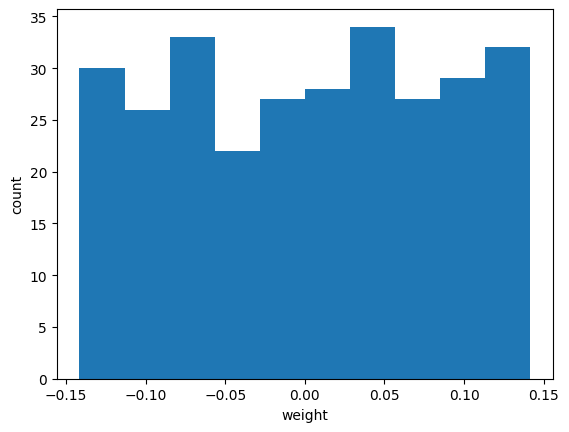

In [16]:
plt.hist(no_training_weights.reshape(-1,1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

이 그래프는 이전과 확실히 다르다. 대부분의 가중치가 -0.15 ~0.15 사이에 있고 비교적 고른 분포를 보인다. 이런 이유는 텐서플로가 신경망의 가중치를 처음 초기화할 때 균등 분포에서 랜덤하게 값을 선택했기 때문이다.

이 가중치 값을 맷플롯립의 imshow() 함수를 사용해 이전처럼 그림으로 출력해 보겠다.

학습된 가중치와 비교하기 위해 동일하게 vmin과 vmax를 -0.5와0.5로 설정한다.


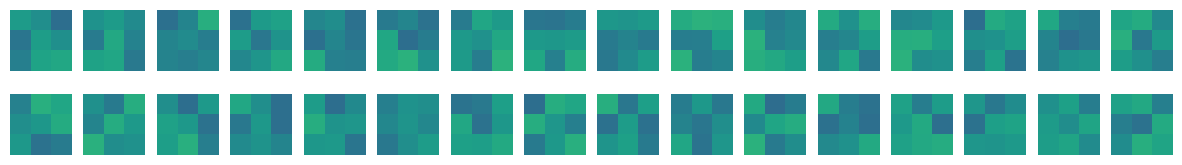

In [18]:
fig,axs = plt.subplots(2,16,figsize=(15,2))
for i in range(2):
  for j in range(16):
    axs[i,j].imshow(no_training_weights[:,:,0,i*16 + j],vmin=-0.5,vmax = 0.5)
    axs[i,j].axis('off')

plt.show()

히스토그램에서 보았듯이 전체적으로 가중치가 밋밋하게 초기화되었다. 이 그림을 훈련이 끝난 이전 가중치와 비교해 보자.

합성곱 신경망이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습했다는 사실을 눈치챌 수 있다.

합성곱 신경망의 학습을 시각화하는 두 번째 방법은 합성곱 층에서 출력된 특성 맵을 그려 보는 것이다. 이를 통해 입력 이미지를 신경망 층이 어떻게 바라보는지 엿볼 수 있다. 합성곱 층의 출력을 만들기 전에 케라스의 함수형 API에 대해 잠시 알아보겠다.

---

# 함수형 API

지금까지는 신경망 모델을 만들 때 케라스 Sequential 클래스를 사용했다. 이 클래스는 층을 차례대로 쌓은 모델을 만든다. 딥러닝에서는 좀 더 복잡한 모델이 많다. 예를 들어 입력이 2개일 수도 있고 출력이 2개일 수도 있다. 이런 경우는 Sequential 클래스를 사용하기 어렵다. 대신 함수형 API를 사용한다.

함수형 API는 케라스의 Model 클래스를 사용하여 모델을 만든다.

간단한 예를 들어보자.

7장에서 만들었던 Dense 층 2개로 이루어진 완전 연결 신경망을 함수형 API로 구현해 보겠다.
* 먼저 2개의 Dense 층 객체를 만든다

In [19]:
dense1 = keras.layers.Dense(100,activation='sigmoid')
dense2 = keras.layers.Dense(10,activation = 'softmax')


위의 코드는 7장에서 보았던 것과 거의 동일하다. 이 객체를 Sequential 클래스 객체의 add() 메서드에 전달할 수 있다.

하지만 다음과 같이 함수처럼 호출할 수도 있다.


In [20]:
hidden  = dense1(inputs)


사실 파이썬의 모든 객체는 호출이 가능하다. 케라스의 층은 객체를 함수처럼 호출했을 때 적절히 동작할 수 있도록 미리 준비해 놓았다. 앞의 코드를 실행하면 영리하게도 입력값 inputs을 Dense층에 통과시킨 후 출력값 hidden을 만들어 준다.

이제 왜 함수형 API라고 부르는지 이해했을 것 같다.

그다음 두 번째 층을 호출한다. 이때는 첫 번째 층의 출력을 입력으로 사용한다.

In [ ]:
outputs = dense2(hidden)

그다음 inputs와 outputs을 Model 클래스로 연결해 주면 된다.


In [ ]:
model = keras.Model(inputs,outputs)

이 과정을 그림으로 나타내면 다음과 같다.

<그림>

입력에서 출력까지 층을 호출한 결과를 계속 이어주고 Model 클래스에 입력과 최종 출력을 지정한다.

그런데 inputs은 어디서 온 걸까? 이전 절에서 plot_model() 함수로 모델의 층을 도시확했을 때 InputLayer 클래스가 맨 처음 나왔던 것을 기억할 것이다. Sequential클래스는 InputLayer클래스를 자동으로 추가하고 호출해 주지만 Model 클래스에서는 우리가 수동으로 만들어서 호출해야 한다. 바로 Inputs가 InputLayer클래스의 출력값이 되어야 한다.

>> Sequential 클래스에서 InputLayer의 객체는 어디에 저장되어 있나?: 케라스 모델은 layers 속성 외에 InputLayer 객체를 포함한 _self_tracked_trackables 리스트 속성을 따로 가지고 있다. Sequential 클래스 객체의 _self_tracked_trackables 속성의 첫 번째 항목이 바로 InputLayer 클래스의 객체이다. InputLayer 클래스는 신경망의 입력층 역할을 한다. 즉 모델의 입력을 첫 번째 은닉층에 전달하는 역할을 수행한다. 따라서 InputLayer 객체의 입력과 출력은 동일하다.

다행히 케라스는 InputLayer 클래스 객체를 쉽게 다룰 수 있도록 Input() 함수를 별도로 제공한다. 입력의 크기는 지정하는 shape 매개변수와 함께 이 함수를 호출하면 InputLayer 클래스 객체를 만들어 출력을 반환해 준다.



In [21]:
inputs = keras.Input(shape=(784,))

전체를 합쳐보면 다음과 같아.
<그림>

마치 체인처럼 입력에서 출력까지 연결하고 마지막에 Model 클래스에 입력과 출력을 지정하여 모델을 만든다. 이렇게 모델을 만들게 되면 중간에 다양한 형태로 층을 연결할 수 있다.

그런데 특성 맵 시각화를 만드는데 함수형 API가 왜 필요할까?

2절에서 정의한 model 객체의 층을 순서대로 나열하면 다음과 같다.

model객체 - InputLayer - Conv2D - Maxpooling2D - Conv2D - Maxpooling2D - Flatten - Dense - Dropout - Dense

우리가 필요한 것은 첫 번째 Conv2D의 출력이다. model 객체의 입력과 Conv2D의 출력을 알 수 있다면 이 둘을 연결하여 새로운 모델을 얻을 수 있지 않을까?

<>

model 객체의 predict() 메서드를 호출하면 입력부터 마지막 층까지 모든 계산을 수행한 후 최종 출력을 반환한다.

하지만 우리가 필요한 것은 첫 번째 Conv2D 층이 출력한 특성 맵이다.

첫 번째 층의 출력은 Conv2D 객체의 output 속성에서 얻을 수 있다. model.layers[0].output처럼 참조할 수 있다.

model 객체의 입력은 어떻게 얻을 수 있을까?

다행히 케라스 모델은 input 속성으로 입력을 참조할 수 있다. 즉 model.input으로 이 모델의 입력을 간단히 얻을 수 있다.



In [22]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


이제 model.input과 model.layers[0].output을 연결하는 새로운 conv_acti 모델을 만들 수 있다.


In [23]:
conv_acti = keras.Model(model.input,model.layers[0].output)

model 객체의 predict() 메서드를 호출하면 최종 출력층의 확률을 반환한다.

하지만 conv_acti의 predict() 메서드를 호출하면 첫 번째 Conv2D의 출력을 반환할 것이다.

이제 준비를 마쳤으니 특성 맵을 시각화해 보자.

---

# 특성 맵 시각화

케라스로 패션 MNIST 데이터셋을 읽은 후 훈련 세트에 있는 첫 번째 샘플을 그려 보겠다.





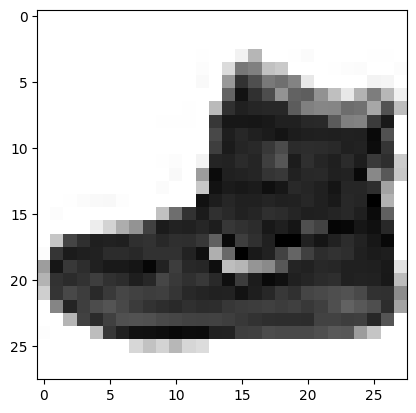

In [24]:
(train_input,train_target),(test_input,test_target) = keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0],cmap='gray_r')
plt.show()

이 샘플을 conv_acti 모델에 주입하여 Conv2D 층이 만드는 특성 맵을 출력해 보겠다.

앞에서도 설명했지만 predict() 메서드는 항상 입력의 첫 번째 차원이 배치 차원일 것으로 기대한다.

하나의 샘플을 전달하더라도 꼭 첫 번째 차원을 유지해야 한다.

이를 위해 슬라이싱 연산자를 사용해 첫 번째 샘플을 선택한다.

그다음에(784,) 크기를 (28,28,1) 크기로 변경하고 255로 나눈다.

In [25]:
inputs = train_input[0:1].reshape(-1,28,28,1) / 255.0
feature_maps = conv_acti.predict(inputs)

1/1 [==============================] - 0s 198ms/step


conv_acti.predict() 메서드가 출력한 feature_maps의 크기를 확인해 보자


In [26]:
print(feature_maps.shape)

(1, 28, 28, 32)


세임 패딩과 32개의 필터를 사용한 합성곱 층의 출력이므로 (28,28,32)이다.

첫 번째 차원은 배치 차원이라는 점을 기억하자. 샘플을 하나 입력했기 때문에 1이 된다.

이제 앞에서와 같이 맷플롯립의 imshow 함수로 이 특성 맵을 그려 보겠다.

총 32개의 특성 맵이 있으므로 4개의 행으로 나누어 그려 보겠다.

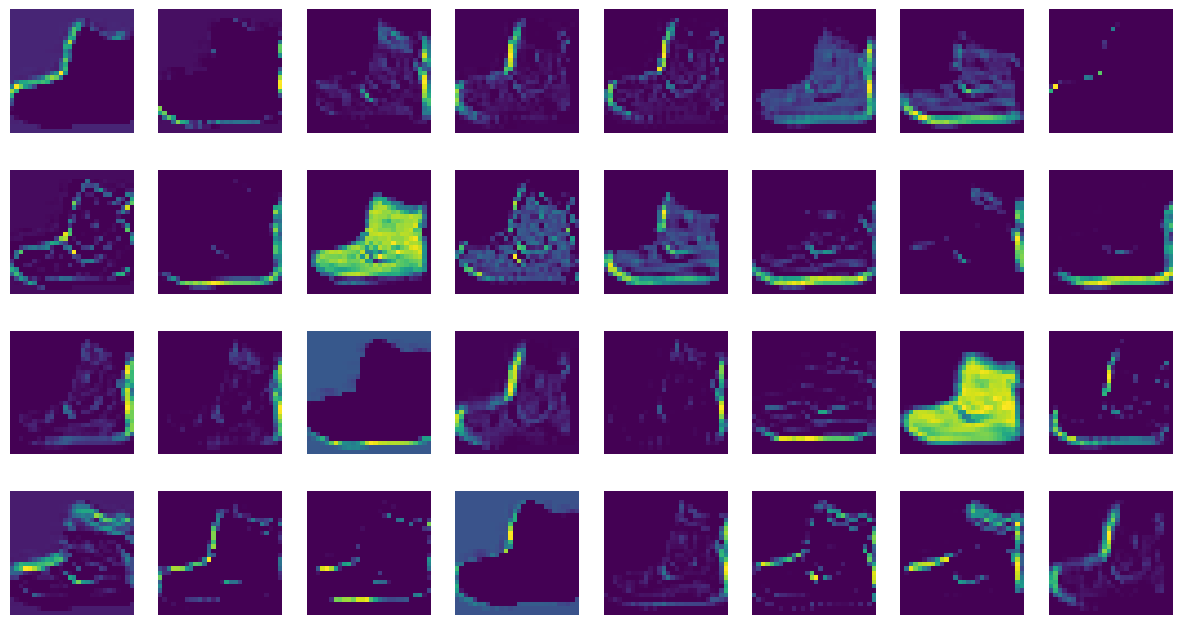

In [27]:
fig,axs = plt.subplots(4,8,figsize=(15,8))
for i in range(4):
  for j in range(8):
    axs[i,j].imshow(feature_maps[0,:,:,i * 8 + j])
    axs[i,j].axis('off')
plt.show()

이 특성 맵은 32개의 필터로 인해 입렵 이미지에서 강하게 활성화된 부분을 보여 준다. 앞서 32개 필터의 가중치를 출력한 그림과 몇 개를 비교해 보겠다.

다음 그림에서 첫 번째 필터는 오른쪽에 있는 수직선을 감지한다. 첫 번째 특성 맵은 이 필터가 감지한 수직선이 강하게 활성화되었다.

세 번째 필터는 전체적으로 밝은색이므로 전면이 모두 칠해진 영역을 감지한다. 세 번째 특성 맵에서 이를 잘 확인할 수 있다. 흑백 부츠 이미지에서 검은 영역이 모두 잘 활성화되어 있다.

이와 반대로 마지막 필터는 전체적으로 낮은 음수 값이다. 이 필터와 큰 양수가 곱해지면 더 큰 음수가 되고 배경처럼 0에 가까운 값과 곱해지면 음수가 될 것이다. 즉 부츠의 배경이 상대적으로 크게 활성화될 수 있다. 이 결과를 마지막 특성 맵에서 잘 볼 수 있다.

<그림>

두 번째 합성곱 층이 만든 특성 맵도 같은 방식으로 확인할 수 있다. 먼저 model 객체의 입력과 두 번째 합성곱 층인 model.layers[2]의 출력을 연결한 conv2_acti 모델을 만든다.





In [28]:
conv2_acti = keras.Model(model.input,model.layers[2].output)


그다음 첫 번쨰 샘플을 conv2_acti 모델의 predict() 메서드에 전달한다.



In [29]:
inputs = train_input[0:1].reshape(-1,28,28,1) / 255.0
feature_maps = conv2_acti.predict(inputs)

1/1 [==============================] - 0s 114ms/step


첫 번째 풀링 층에서 가로세로 크기가 절반으로 줄었고, 두 번째 합성곱 층의 필터 개수는 64개이므로 feature_maps의 크기는 배치 차원을 제외하면 (14,14,64)일 것이다.

In [30]:
print(feature_maps.shape)

(1, 14, 14, 64)


* 64개의 특성 맵을 8개씩 나누어 imshow() 함수로 그려 보겠다.


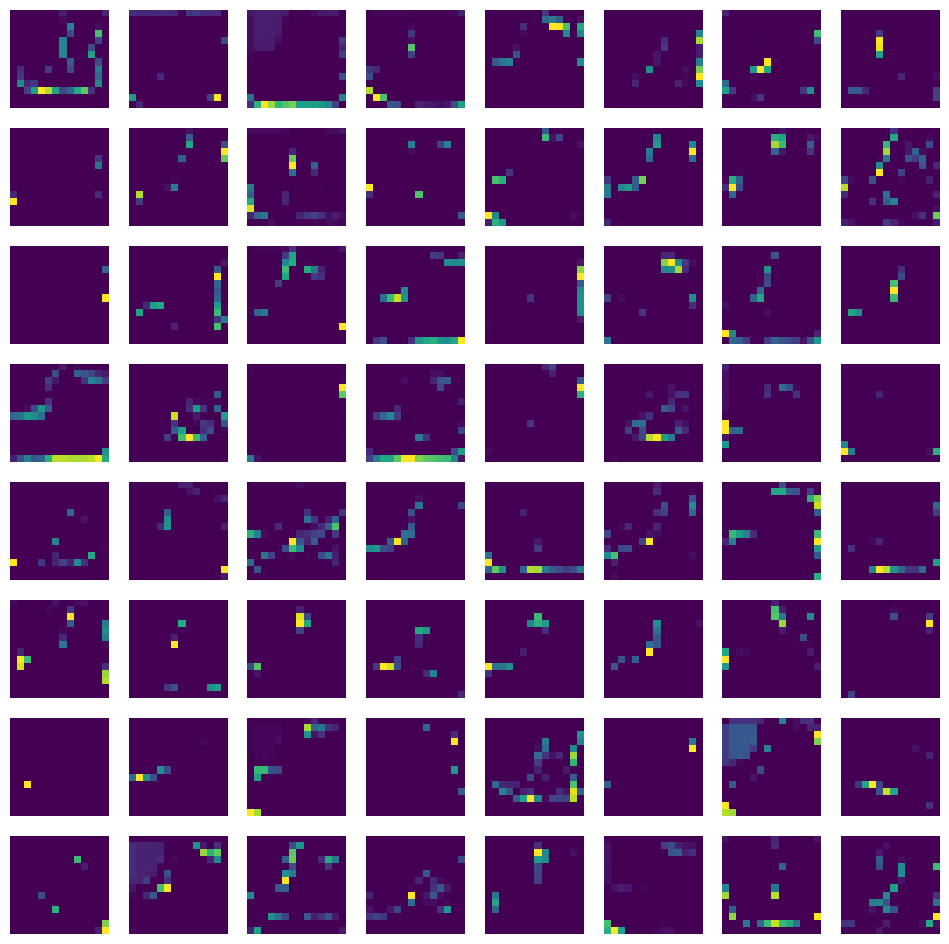

In [31]:
fig,axs = plt.subplots(8,8,figsize = (12,12))
for i in range(8):
  for j in range(8):
    axs[i,j].imshow(feature_maps[0,:,:,i*8 + j])
    axs[i,j].axis('off')
plt.show()

이 특성 맵은 시각적으로 이해하기 어렵다. 왜 이렇지??

두 번째 합성곱 층의 필터 크기는 (3,3,32)이다. 두 번째 합성곱 층의 첫 번째 필터가 앞서 출력한 32개의 특성 맵과 곱해져 두 번째 합성곱 층의 첫 번째 특성 맵이 된다. 다음의 그림처럼 이렇게 계산된 출력은 (14,14,32) 특성 맵에서 어떤 부위를 감지하는지 직관적으로 이해하기 어렵다.

<그림>

이런 현상은 합성곱 층을 많이 쌓을수록 심해진다. 이를 바꾸어 생각하면 합성곱 신경망의 앞부분에 있는 합성곱 층은 이미지의 시각화 정보를 감지하고 뒤쪽에 있는 합성곱 층은 앞쪽에서 감지한 시각적인 정보를 바탕으로 추상적인 정보를 학습한다고 볼 수 있다. 합성곱 신경망이 패션 MNIST 이미지를 인식하여 10개의 클래스를 찾아낼 수 있는 이유가 바로 여기에 있다.

